# OBJECTIVE:
                      1)Applying GBDT and Random Forest on Different Featurization of Data viz unigram,tfidf, Avg-W2V and AVGtf-idf-W2V
                      2)Finding the best hyperparameters by using cross validation
                      3)Get Important Features and represent them in word cloud

In [1]:
import sqlite3
import pandas as pd
import numpy as np
con=sqlite3.connect("database.sqlite")
data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)
def partitions(x):
    if x < 3:
        return "negative"
    return "positive"
score=data["Score"]
positive_negative=score.map(partitions)
data["Score"]=positive_negative
#Here I am just sorting the data
sorted_data=data.sort_values("ProductId",ascending=True,inplace=False,na_position="last")
#Here I am dropping the fake reviews (repeated reviews)
Final_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
#Again I am filtering the data by using this condition
Final_data=Final_data[Final_data.HelpfulnessNumerator <= Final_data.HelpfulnessDenominator]
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
import re
##functions to clean html and punctuation
stop=set(stopwords.words("english"))#set stop words  
snow=nltk.stem.SnowballStemmer("english")    #its give the stem word of particular word(eg:happy--happi)
def clearhtml(sentence):#In cleanhtml function we taking all the html tag by using regular expression
    cleanr=re.compile("<.*?>")
    clean=re.sub(cleanr," ",sentence)
    return clean
def clearpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned
#here we just filtered the reviews ie:preprocessing the data
#1)clean the html tags in whole Final_data["Text"]
#2)clean the punctuation in whole Final_data["Text"] by word by word('w')
#3)check whether its alphabet or not and also length of the word should be more than 2
#4)And change it into lower case and check  those words are not in stop word if its in stopwords its eliminate it
#5)And we stemming each word and encode it

i=0
str=' '
clean_string=[]
positive_word=[]
negative_word=[]
for stem in Final_data["Text"]:
    Filtered_word=[]
    stem=clearhtml(stem)
    #print(stem)
    for word in stem.split():
        for clean_word in clearpunc(word).split():
            if clean_word.isalpha() and len(clean_word) >2:
                if clean_word.lower() not in stop:
                    s=snow.stem(clean_word.lower()).encode("utf8")
                    Filtered_word.append(s)
                    if (Final_data["Score"].values)[i] == "positive":
                        positive_word.append(s)
                    if(Final_data["Score"].values)[i]  == "negative":
                        negative_word.append(s)
                else:
                    continue
            else:
                continue
    str1=b" ".join(Filtered_word)
    clean_string.append(str1)
    i+=1
Final_data["cleaned_data"]=clean_string
Final_data["cleaned_data"]=Final_data["cleaned_data"].str.decode('utf8')
#sorting my dataframe in TBS
import datetime

Final_data["Time"] = Final_data["Time"].map(lambda t: datetime.datetime.fromtimestamp(int(t)).strftime('%Y-%m-%d %H:%M:%S'))
sorted_data=Final_data.sort_values("Time",ascending=True,kind="quicksort",inplace=False,axis=0).reset_index(drop=True)


In [2]:
data_40k=sorted_data.head(80000)
data_40k['Score'].value_counts()
data_40k.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_data
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 05:30:00,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 05:30:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 05:30:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
3,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 05:30:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
4,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 05:30:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [3]:
data_40k['Score'] = [1 if b=='positive' else 0 for b in data_40k['Score']]

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [4]:

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data_40k,data_40k['Score'],test_size=0.3,random_state=42,shuffle=False)
X_tr,X_cv,y_tr,y_cv=train_test_split(X_train,y_train,test_size=0.3,shuffle=False)
print(X_tr.shape)
print(X_test.shape)
print(X_cv.shape)
#print(y_train)

(39200, 11)
(24000, 11)
(16800, 11)


# AVGW2V

In [6]:
from gensim.models import Word2Vec    
from gensim.models import KeyedVectors

i=0
list_of_sent=[]
for sent in X_tr['cleaned_data'].values:
    list_of_sent.append(sent.split())

C:\Users\Admin\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=200, workers=4)
w2v_words=list(w2v_model.wv.vocab)

In [8]:
Avg_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_tr['cleaned_data']: 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_train.append(sent_vec)
print(len(Avg_w2v_train))
print(len(Avg_w2v_train[0]))

39200
200


In [9]:
Avg_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_test['cleaned_data']: 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_test.append(sent_vec)
print(len(Avg_w2v_test))
print(len(Avg_w2v_test[0]))

24000
200


In [10]:
Avg_w2v_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_cv['cleaned_data']: 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; 
    for word in sent.split(): # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]#wv is used to convrt word into vector
            sent_vec += vec #we adding that vector into zeros[50]
            cnt_words += 1 #the valid vector increasing by 1
    if cnt_words != 0: #if its an valid vector
        sent_vec /= cnt_words
    Avg_w2v_cv.append(sent_vec)
print(len(Avg_w2v_cv))
print(len(Avg_w2v_cv[0]))
#print(Avg_w2v_cv)

16800
200


In [11]:
#print(mask)
#print(Avg_w2v_train)
from sklearn.preprocessing import StandardScaler
gbdt_stnd=StandardScaler(with_mean=False).fit(Avg_w2v_train)
X_train_stnd2=gbdt_stnd.transform(Avg_w2v_train)
X_test_stnd2=gbdt_stnd.transform(Avg_w2v_test)
X_cv_stnd2=gbdt_stnd.transform(Avg_w2v_cv)

# GBDT

In [12]:
#print(avg_vec_norm)
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
best=[]
GBDT = GradientBoostingClassifier()
param_grid = {'max_depth':range(1,20,4),'learning_rate':[round(random.uniform(0.1, 1.0), 10)],"n_estimators":[100,200,300,400,500]} #params we need to try on classifier
gsv = GridSearchCV(GBDT,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'learning_rate': 0.6040900879, 'max_depth': 1, 'n_estimators': 500}
Best Accuracy: 94.94%


In [13]:
lr=best[0]["learning_rate"]
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

In [14]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
import scikitplot.metrics as skplt
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(X_train_stnd2,y_tr)
y_pred = GBDT.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
#skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on cv set: 89.619%
Precision on cv set: 88.021
Recall on cv set: 89.619
F1-Score on  cv set: 88.043
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



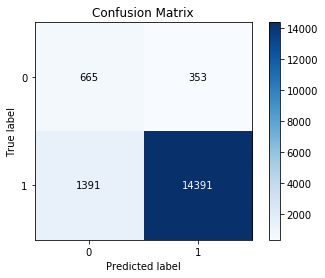

In [15]:
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 89.342%
Precision on test set: 87.988
Recall on test set: 89.342
F1-Score on  test set: 87.874
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



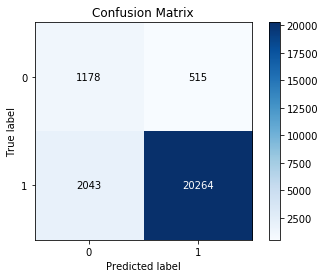

In [16]:

y_pred = GBDT.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

In [17]:
def split(arr, size):
     arrs = []
     while len(arr) > size:
         pice = arr[:size]
         arrs.append(pice)
         arr   = arr[size:]
     arrs.append(arr)
     return arrs

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


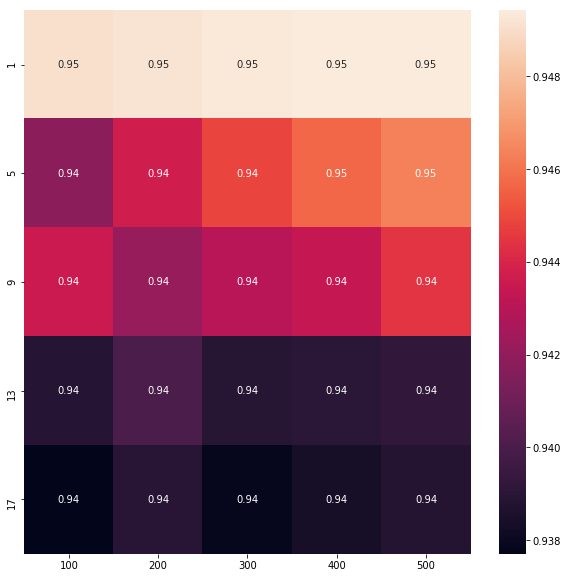

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# RF for AVG w2v

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [24]:
best=[]
RF=RandomForestClassifier(class_weight="balanced")
param_grid={"n_estimators":[100,200,300,400,500],"max_depth":(range(1,20,4))}
gsv=GridSearchCV(RF,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'max_depth': 17, 'n_estimators': 500}
Best Accuracy: 94.72%


In [25]:

depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 89.131%
Precision on cv set: 87.302
Recall on cv set: 89.131
F1-Score on  cv set: 87.485
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



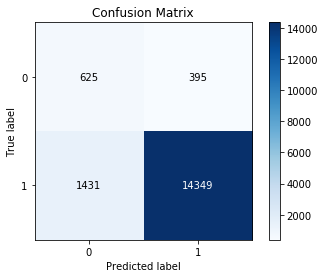

In [26]:
RF=RandomForestClassifier(class_weight="balanced",max_depth=depth,n_estimators=esti)
RF.fit(X_train_stnd2,y_tr)
y_pred=RF.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 88.787%
Precision on test set: 87.249
Recall on test set: 88.787
F1-Score on  test set: 87.391
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



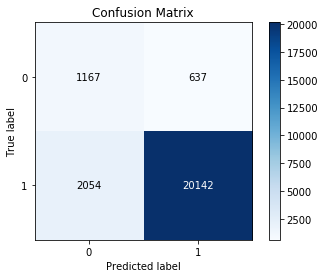

In [27]:
y_pred = RF.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


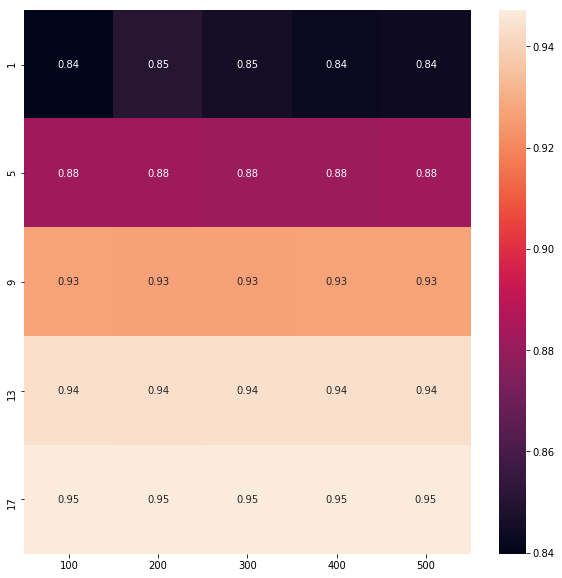

In [29]:
import matplotlib.pyplot as plt
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# TFIDF

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer  #tf is calculated by no of wi occurs in rj/no of words in rj 
from sklearn.feature_extraction.text import TfidfVectorizer    #idf is calculated by no of docs/docs which contains wi                                                 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features=300)#tfidf=tf*idf
final_tfidf = tf_idf_vect.fit(X_tr["cleaned_data"].values)
tfidf_train=tf_idf_vect.transform(X_tr["cleaned_data"])
tfidf_test=tf_idf_vect.transform(X_test["cleaned_data"])
tfidf_cv=tf_idf_vect.transform(X_cv["cleaned_data"])

In [31]:
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [32]:
from sklearn.preprocessing import StandardScaler
gbdt_stnd=StandardScaler(with_mean=False).fit(tfidf_train)
X_train_stnd2=gbdt_stnd.transform(tfidf_train)
X_test_stnd2=gbdt_stnd.transform(tfidf_test)
X_cv_stnd2=gbdt_stnd.transform(tfidf_cv)

# GBDT

In [33]:
import random
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
best=[]
GBDT = GradientBoostingClassifier()
param_grid = {'max_depth':range(1,20,4),'learning_rate':[round(random.uniform(0.1, 1.0), 10)],"n_estimators":[100,200,300,400,500]} #params we need to try on classifier
gsv = GridSearchCV(GBDT,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'learning_rate': 0.4772745346, 'max_depth': 1, 'n_estimators': 400}
Best Accuracy: 94.78%


In [34]:
lr=best[0]["learning_rate"]
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 89.363%
Precision on cv set: 87.674
Recall on cv set: 89.363
F1-Score on  cv set: 86.961
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



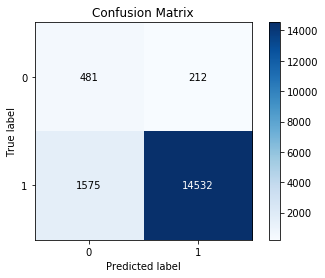

In [35]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,classification_report
import scikitplot.metrics as skplt
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(X_train_stnd2,y_tr)
y_pred = GBDT.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 88.775%
Precision on test set: 87.346
Recall on test set: 88.775
F1-Score on  test set: 86.370
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



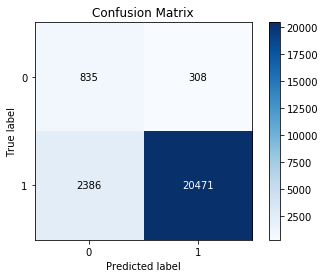

In [36]:
y_pred = GBDT.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


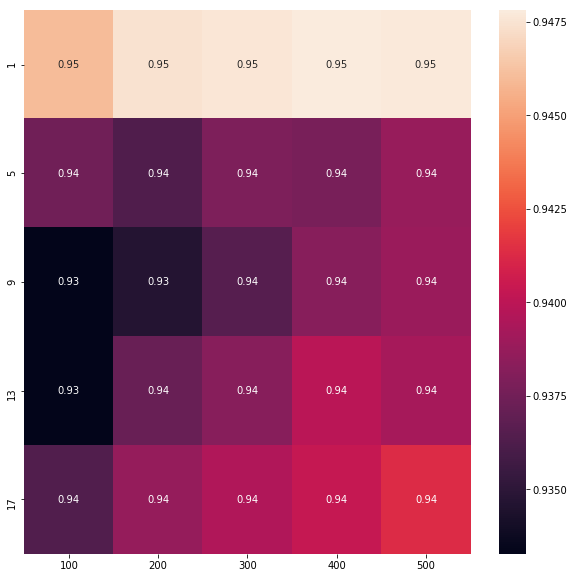

In [37]:
import matplotlib.pyplot as plt
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# Random Forest for TFIDF

In [38]:
best=[]
RF=RandomForestClassifier(class_weight="balanced")
param_grid={"n_estimators":[100,200,300,400,500],"max_depth":(range(1,20,4))}
gsv=GridSearchCV(RF,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'max_depth': 17, 'n_estimators': 100}
Best Accuracy: 89.89%


In [39]:
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 80.744%
Precision on cv set: 87.415
Recall on cv set: 80.744
F1-Score on  cv set: 83.107
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



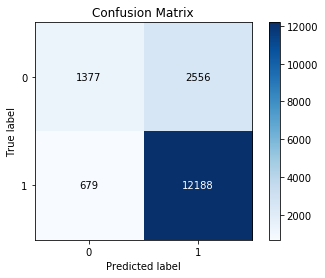

In [40]:
RF=RandomForestClassifier(class_weight="balanced",max_depth=depth,n_estimators=esti)
RF.fit(X_train_stnd2,y_tr)
y_pred=RF.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 80.812%
Precision on test set: 86.908
Recall on test set: 80.812
F1-Score on  test set: 82.928
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



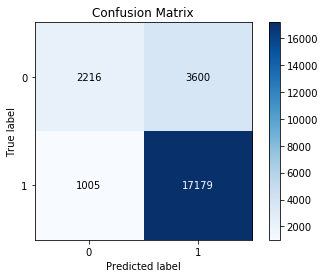

In [41]:
y_pred = RF.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

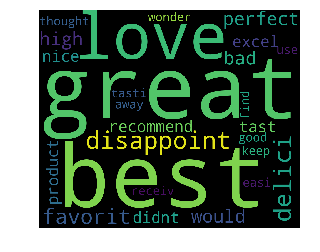

In [42]:
importances=RF.feature_importances_
feat_names=tf_idf_vect.get_feature_names()
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def againcleaning(X):
    
    comment_words=' '
    for words in X: 
    
        comment_words = comment_words + words + ' '
    return comment_words
a=againcleaning(a)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
word_cloud=WordCloud(background_color='black',stopwords=stop,
                          width=1200,
                          height=1000).generate(a)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()   
    
    

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


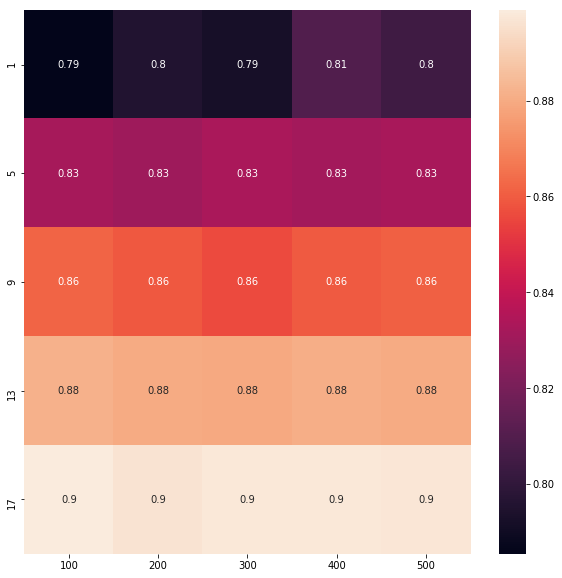

In [43]:
import matplotlib.pyplot as plt
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer  #tf is calculated by no of wi occurs in rj/no of words in rj 
from sklearn.feature_extraction.text import TfidfVectorizer    #idf is calculated by no of docs/docs which contains wi                                                 
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))#tfidf=tf*idf
final_tfidf = tf_idf_vect.fit(X_tr["cleaned_data"].values)
tfidf_train=tf_idf_vect.transform(X_tr["cleaned_data"])
tfidf_test=tf_idf_vect.transform(X_test["cleaned_data"])
tfidf_cv=tf_idf_vect.transform(X_cv["cleaned_data"])
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


# AVG TFIDF W2V

In [46]:

tfidf_feat = tf_idf_vect.get_feature_names() 

tfidf_sent_vectors = [];
row=0;
for sent in X_tr["cleaned_data"]: 
    sent_vec = np.zeros(200) 
    weight_sum =0; 
    #print(sent)
    for word in sent.split(): 
       # print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tfidf_train[row, tfidf_feat.index(word)]
            tf_idf = dictionary[word]*sent.count(word)
           # print(tf_idf)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
       # print(sent_vec)
    tfidf_sent_vectors.append(sent_vec)
   # print(sent_vec)
    row += 1

In [47]:

tfidf_sent_vectors_test = [];
row=0;
for sent in X_test["cleaned_data"]: 
    sent_vec = np.zeros(200) 
    weight_sum =0; 
    for word in sent.split(): 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

In [48]:

tfidf_sent_vectors_cv = [];
row=0;
for sent in X_cv["cleaned_data"]: 
    sent_vec = np.zeros(200) 
    weight_sum =0; 
    for word in sent.split(): 
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
#print(tfidf_sent_vectors_cv)

# GBDT for AVGTFIDF

In [49]:
#print(avg_vec_norm)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
best=[]
GBDT = GradientBoostingClassifier()
param_grid = {'max_depth':range(1,20,4),'learning_rate':[round(random.uniform(0.1, 1.0), 10)],"n_estimators":[100,200,300,400,500]} #params we need to try on classifier
gsv = GridSearchCV(GBDT,param_grid,cv=3,scoring="f1")
gsv.fit(tfidf_sent_vectors,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'learning_rate': 0.9272196103, 'max_depth': 1, 'n_estimators': 100}
Best Accuracy: 94.42%


In [50]:
lr=best[0]["learning_rate"]
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 88.595%
Precision on cv set: 86.242
Recall on cv set: 88.595
F1-Score on  cv set: 86.288
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



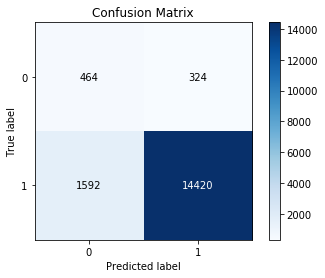

In [51]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import scikitplot.metrics as skplt
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(tfidf_sent_vectors,y_tr)
y_pred = GBDT.predict(tfidf_sent_vectors_cv)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 88.067%
Precision on test set: 86.009
Recall on test set: 88.067
F1-Score on  test set: 85.828
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



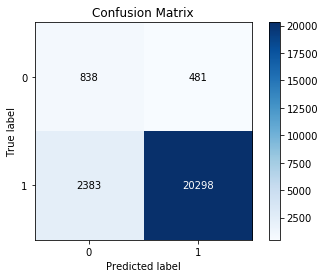

In [52]:
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(tfidf_sent_vectors,y_tr)
y_pred = GBDT.predict(tfidf_sent_vectors_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


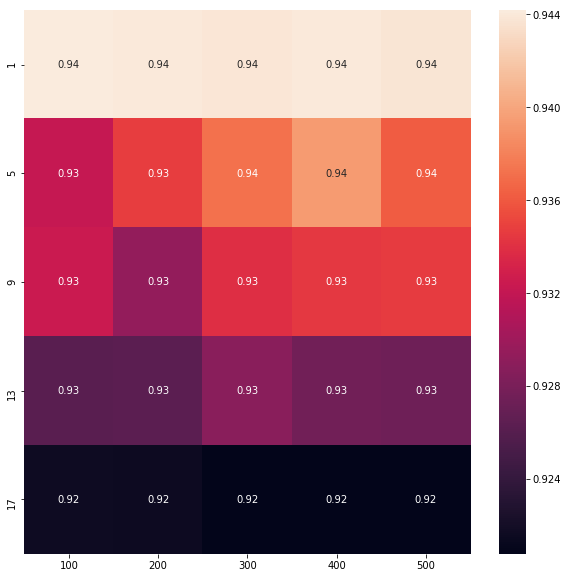

In [53]:
import matplotlib.pyplot as plt
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# RandomForest for AVGW2V TFIDF

In [54]:
best=[]
RF=RandomForestClassifier(class_weight="balanced")
param_grid={"n_estimators":[100,200,300,400,500],"max_depth":(range(1,20,4))}
gsv=GridSearchCV(RF,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(tfidf_sent_vectors,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'max_depth': 17, 'n_estimators': 300}
Best Accuracy: 94.50%


In [55]:
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 88.613%
Precision on cv set: 86.373
Recall on cv set: 88.613
F1-Score on  cv set: 86.579
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



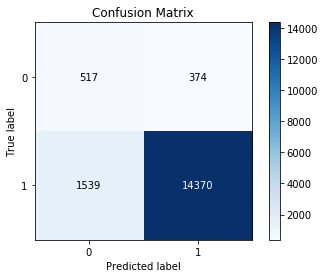

In [56]:
RF=RandomForestClassifier(class_weight="balanced",max_depth=depth,n_estimators=esti)
RF.fit(tfidf_sent_vectors,y_tr)
y_pred=RF.predict(tfidf_sent_vectors_cv)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 88.021%
Precision on test set: 86.031
Recall on test set: 88.021
F1-Score on  test set: 86.179
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



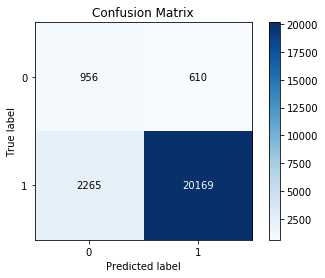

In [57]:
y_pred = RF.predict(tfidf_sent_vectors_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


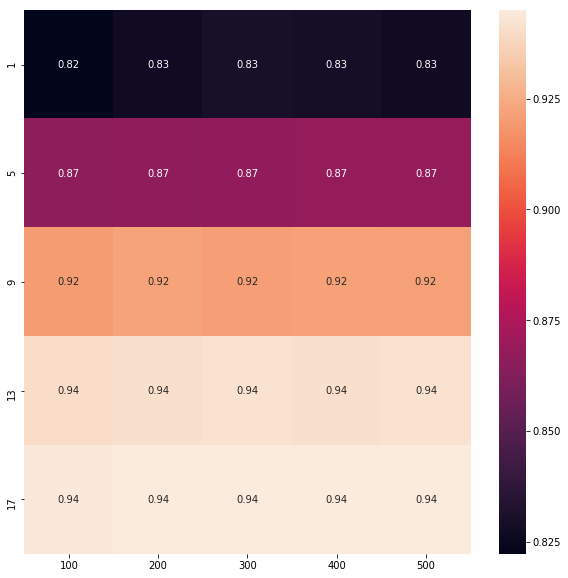

In [58]:
import matplotlib.pyplot as plt
maxx=[]
esty=[]
mean=[]
for a in gsv.grid_scores_:
    #print(a[1])
    maxx.append(a[0]['max_depth']) 
    esty.append(a[0]['n_estimators'])
    mean.append(a[1])
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# BOW

In [59]:
#bag of words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
cnt_vector=CountVectorizer(max_features=100000)
fit_Xtrain=cnt_vector.fit(X_tr["cleaned_data"])
trans_Xtrain=cnt_vector.transform(X_tr["cleaned_data"])
trans_Xtest=cnt_vector.transform(X_test["cleaned_data"])
trans_Xcv=cnt_vector.transform(X_cv["cleaned_data"])
trans_Xtest.shape

(24000, 24226)

In [60]:
from sklearn.preprocessing import StandardScaler
std_svm=StandardScaler(with_mean=False).fit(trans_Xtrain)
X_train_stnd2=std_svm.transform(trans_Xtrain)
X_test_stnd2=std_svm.transform(trans_Xtest)
X_cv_stnd2=std_svm.transform(trans_Xcv)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [61]:
#print(avg_vec_norm)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
best=[]
GBDT = GradientBoostingClassifier()
param_grid = {'max_depth':range(1,20,4),'learning_rate':[round(random.uniform(0.1, 1.0), 10)],"n_estimators":[100,200,300,400,500]} #params we need to try on classifier
gsv = GridSearchCV(GBDT,param_grid,cv=3,scoring="f1")
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'learning_rate': 0.1911593947, 'max_depth': 5, 'n_estimators': 400}
Best Accuracy: 95.47%


In [62]:
lr=best[0]["learning_rate"]
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

In [72]:
gsv.grid_scores_

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.79979, std: 0.00838, params: {'max_depth': 1, 'n_estimators': 100},
 mean: 0.86893, std: 0.01831, params: {'max_depth': 1, 'n_estimators': 200},
 mean: 0.90045, std: 0.00751, params: {'max_depth': 1, 'n_estimators': 300},
 mean: 0.90183, std: 0.00651, params: {'max_depth': 1, 'n_estimators': 400},
 mean: 0.91248, std: 0.00937, params: {'max_depth': 1, 'n_estimators': 500},
 mean: 0.90179, std: 0.00473, params: {'max_depth': 5, 'n_estimators': 100},
 mean: 0.91649, std: 0.00273, params: {'max_depth': 5, 'n_estimators': 200},
 mean: 0.92412, std: 0.00429, params: {'max_depth': 5, 'n_estimators': 300},
 mean: 0.92336, std: 0.00569, params: {'max_depth': 5, 'n_estimators': 400},
 mean: 0.92513, std: 0.00455, params: {'max_depth': 5, 'n_estimators': 500},
 mean: 0.92667, std: 0.00117, params: {'max_depth': 9, 'n_estimators': 100},
 mean: 0.92942, std: 0.00323, params: {'max_depth': 9, 'n_estimators': 200},
 mean: 0.93037, std: 0.00168, params: {'max_depth': 9, 'n_estimators': 300},

Accuracy on cv set: 90.696%
Precision on cv set: 89.668
Recall on cv set: 90.696
F1-Score on  cv set: 89.151
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



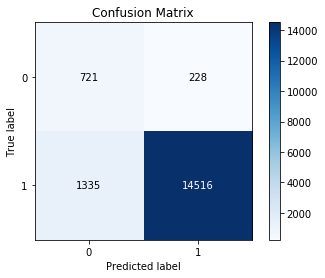

In [63]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
import scikitplot.metrics as skplt
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(X_train_stnd2,y_tr)
y_pred = GBDT.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 90.404%
Precision on test set: 89.542
Recall on test set: 90.404
F1-Score on  test set: 88.993
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



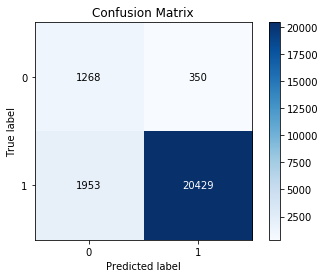

In [64]:
GBDT = GradientBoostingClassifier(max_depth=depth,learning_rate=lr,n_estimators=esti)
GBDT.fit(X_train_stnd2,y_tr)
y_pred = GBDT.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

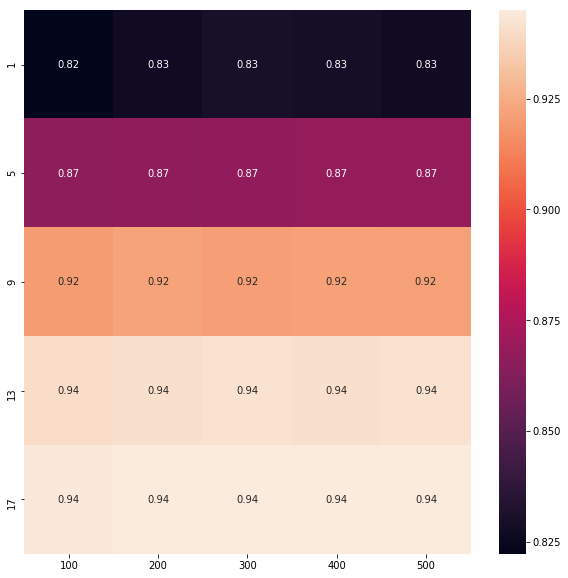

In [65]:
#scores_seperate()
a=split(mean,5)
fig, ax = plt.subplots(figsize=(10,10))
j=pd.DataFrame(a,columns=[100,200,300,400,500],index=[1,5,9,13,17])
sns.heatmap(j,annot=True,ax=ax)

# RF for BOW

In [66]:
best=[]
RF=RandomForestClassifier(class_weight="balanced")
param_grid={"n_estimators":[100,200,300,400,500],"max_depth":(range(1,30,4))}
gsv=GridSearchCV(RF,param_grid,cv=3,scoring="f1",n_jobs=-1)
gsv.fit(X_train_stnd2,y_tr)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
best.append(gsv.best_params_)
#gsv1=gsv.best_score_

Best HyperParameter:  {'max_depth': 29, 'n_estimators': 500}
Best Accuracy: 95.20%


In [67]:
depth=best[0]["max_depth"]
esti=best[0]["n_estimators"]

Accuracy on cv set: 89.881%
Precision on cv set: 89.479
Recall on cv set: 89.881
F1-Score on  cv set: 89.659
Confusion Matrix of cv set:
 [ [TN  FP]
 [FN TP] ]



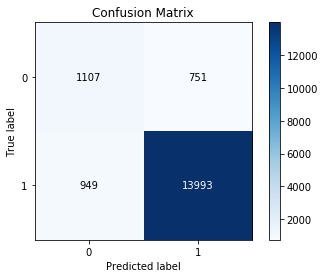

In [68]:
RF=RandomForestClassifier(class_weight="balanced",max_depth=depth,n_estimators=esti)
RF.fit(X_train_stnd2,y_tr)
y_pred=RF.predict(X_cv_stnd2)
print("Accuracy on cv set: %0.3f%%"%(accuracy_score(y_cv, y_pred)*100))
print("Precision on cv set: %0.3f"%(precision_score(y_cv, y_pred,average="weighted")*100))
print("Recall on cv set: %0.3f"%(recall_score(y_cv, y_pred,average="weighted")*100))
print("F1-Score on  cv set: %0.3f"%(f1_score(y_cv, y_pred,average="weighted")*100))
print("Confusion Matrix of cv set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_cv)

Accuracy on test set: 89.892%
Precision on test set: 89.404
Recall on test set: 89.892
F1-Score on  test set: 89.605
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



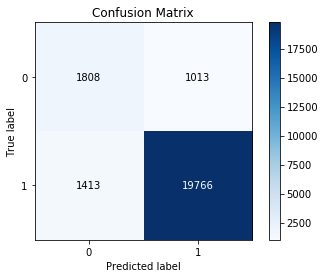

In [69]:
y_pred = RF.predict(X_test_stnd2)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred,average="weighted")*100))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred,average="weighted")*100))
print("F1-Score on  test set: %0.3f"%(f1_score(y_test, y_pred,average="weighted")*100))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
skplt.plot_confusion_matrix(y_pred,y_test)

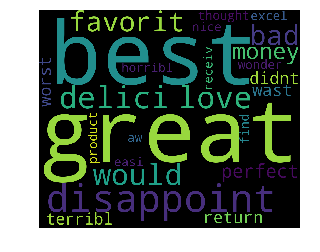

In [70]:
importances=RF.feature_importances_
feat_names=cnt_vector.get_feature_names()
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def againcleaning(X):
    
    comment_words=' '
    for words in X: 
    
        comment_words = comment_words + words + ' '
    return comment_words
a=againcleaning(a)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
word_cloud=WordCloud(background_color='black',stopwords=stop,
                          width=1200,
                          height=1000).generate(a)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()   
    
    

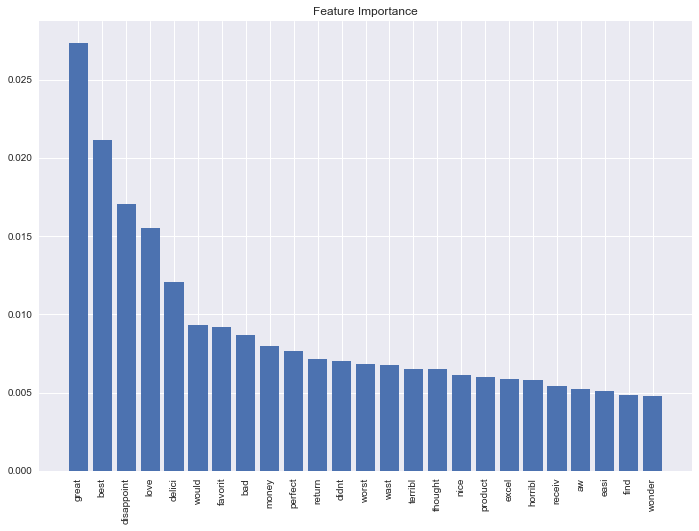

In [71]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(25), importances[indices])

# Add feature names as x-axis labels
feat_names = np.array(feat_names)
plt.xticks(range(25), feat_names[indices], rotation=90)

# Show plot
plt.show()
# uni_gram.get_feature_names()

In [75]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","vectorizer","CV_error", "Test_error","F1 score(train)","F1(Test)"]

x.add_row(["GBDT","AVGW2V","10.39%","10.66%","88.04%","87.87%"])
x.add_row(["RF","AVGW2V","10.87%","11.82%","87.48%","87.39%"])
x.add_row(["GBDT","TFIDF","10.64%","11.22%","87.48%","87.39%"])
x.add_row(["RF","BOW","19.26%","19.19%","83.10%","82.92%"])
x.add_row(["GBDT","AVGW2VTFIDF","11.41%","19.94%","86.28%","85.82%"])
x.add_row(["RF","AVGW2VTFIDF","11.39%","11.98%","86.57%","86.17%"])
x.add_row(["GBDT","BOW","9.31%","9.6%","89.15%","88.99%"])
x.add_row(["RF","BOW","10.12%","10.11%","89.65%","89.60%"])

print(x)

+-------+-------------+----------+------------+-----------------+----------+
| Model |  vectorizer | CV_error | Test_error | F1 score(train) | F1(Test) |
+-------+-------------+----------+------------+-----------------+----------+
|  GBDT |    AVGW2V   |  10.39%  |   10.66%   |      88.04%     |  87.87%  |
|   RF  |    AVGW2V   |  10.87%  |   11.82%   |      87.48%     |  87.39%  |
|  GBDT |    TFIDF    |  10.64%  |   11.22%   |      87.48%     |  87.39%  |
|   RF  |     BOW     |  19.26%  |   19.19%   |      83.10%     |  82.92%  |
|  GBDT | AVGW2VTFIDF |  11.41%  |   19.94%   |      86.28%     |  85.82%  |
|   RF  | AVGW2VTFIDF |  11.39%  |   11.98%   |      86.57%     |  86.17%  |
|  GBDT |     BOW     |  9.31%   |    9.6%    |      89.15%     |  88.99%  |
|   RF  |     BOW     |  10.12%  |   10.11%   |      89.65%     |  89.60%  |
+-------+-------------+----------+------------+-----------------+----------+


# CONCLUSION:
                          1)Both GBDT and RF are good in BOW vectorizer which gives low errors and also the f1 scores are good compare to others
                          2)And I also used word cloud to display the important features.
                          3)And also each hyperparameters error metric has been shown.